In [1]:
import os

os.chdir('..')
datadir = 'data'

import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from shapely.geometry import Point

In [2]:
DEFAULT_CRS = 'EPSG:3857'
SEASONS = ['summer', 'autumn']

# Import PurpleAir and AirNow data archives

## Formatting and cleaning functions

In [3]:
def lower_and_underscore(s):
    return str(s).strip().lower().replace(' ','_')

def import_archive_data(fname, season):
    df = pd.read_csv(fname)
    df['season'] = season
    df.columns = df.columns.to_series().apply(lower_and_underscore)
    return df

## Import AirNow sensor data

In [4]:
# Import summer and autumn AirNow data into a single DataFrame
df_an = pd.DataFrame()
for season in SEASONS:
    fname = os.path.join(datadir, f"{season}_2021_airnow.csv")
    df_tmp = pd.read_csv(fname, index_col=0, parse_dates=['DateTime'])
    df_tmp['season'] = season
    df_tmp.columns = df_tmp.columns.to_series().apply(lower_and_underscore)    
    df_an = df_an.append(df_tmp)

df_an.head()

,latitude,longitude,datetime,parameter,concentration,unit,aqi,category,season
0,41.965000,-87.876100,2021-07-04 02:00:00,OZONE,31.0,PPB,29,1,summer
1,42.060300,-87.863100,2021-07-04 02:00:00,PM2.5,10.5,UG/M3,44,1,summer
2,42.060300,-87.863100,2021-07-04 02:00:00,OZONE,35.0,PPB,32,1,summer
3,41.855301,-87.752502,2021-07-04 02:00:00,OZONE,34.0,PPB,31,1,summer
4,41.864329,-87.748826,2021-07-04 02:00:00,PM2.5,5.3,UG/M3,22,1,summer


In [5]:
# Get PM2.5-specific rows/cols
colList = ['latitude', 'longitude', 'datetime', 'concentration', 'season']
df_an_pm25 = df_an.loc[df_an['parameter'] == 'PM2.5', :][colList].copy()

df_an_pm25.head()

,latitude,longitude,datetime,concentration,season
1,42.060300,-87.863100,2021-07-04 02:00:00,10.5,summer
4,41.864329,-87.748826,2021-07-04 02:00:00,5.3,summer
6,41.913600,-87.723900,2021-07-04 02:00:00,8.2,summer
7,41.754700,-87.713600,2021-07-04 02:00:00,9.0,summer
12,42.060300,-87.863100,2021-07-04 03:00:00,12.2,summer


In [68]:
# Get list of unique sensor coordinates
sensorCoords_an = df_an_pm25[['latitude', 'longitude']].drop_duplicates().sort_values(by='latitude').reset_index()
# In order from southermost to northernmost
locations_an = {0: "Alsip",
                1: "Ashburn",
                2: "Cicero",
                3: "Humbolt Park/Hermosa",
                4: "Des Plaines"}               
sensorCoords_an['location'] = locations_an.values()

print(sensorCoords_an)

   index   latitude  longitude              location
0    732  41.670800 -87.732500                 Alsip
1      7  41.754700 -87.713600               Ashburn
2      4  41.864329 -87.748826                Cicero
3      6  41.913600 -87.723900  Humbolt Park/Hermosa
4      1  42.060300 -87.863100           Des Plaines


## Import PurpleAir sensor data

In [7]:
# Pull list of PurpleAir sensors from JSON file
df_sensors = pd.read_json(os.path.join(datadir, "pa_sensors.json"))
df_sensors.columns = df_sensors.columns.to_series().apply(lower_and_underscore)
df_sensors.rename(columns={'sensorid': 'sensor'}, inplace=True)

# Merge with coordinates for sensors locations (based on looking up intersections on Google Maps)
sensorDict = {0: (41.82863695731357, -87.66789654012659),
                1: (41.82492553658286, -87.67390925492755),
                2: (41.82283856567223, -87.67588687024907)}

df_sensors['coordinates'] = df_sensors.index.map(sensorDict)
df_sensors['latitude'] = df_sensors['coordinates'].apply(lambda x: x[0])
df_sensors['longitude'] = df_sensors['coordinates'].apply(lambda x: x[1])

print(df_sensors[['sensor', 'neighborhood', 'location', 'latitude', 'longitude']])

   sensor   neighborhood               location   latitude  longitude
0   96035  McKinley Park       36th and Paulina  41.828637 -87.667897
1   96395  McKinley Park      38th & Winchester  41.824926 -87.673909
2   94975  McKinley Park  39th and Damen (NLEI)  41.822839 -87.675887


In [8]:
# Import summer and autumn PurpleAir parent (main sensor) data into a single DataFrame,
# merging with sensor coordinates
df_pa = pd.DataFrame()
for season in SEASONS:
    fname = os.path.join(datadir, f"{season}_2021_pa_parent.csv")
    df_tmp = pd.read_csv(fname, parse_dates=['created_at'])
    df_tmp['season'] = season
    df_tmp.columns = df_tmp.columns.to_series().apply(lower_and_underscore)
    df_tmp.rename(columns={'created_at': 'datetime'}, inplace=True)
    df_tmp = df_tmp.merge(df_sensors[['sensor', 'latitude', 'longitude']], how='outer', on='sensor')
    df_pa = df_pa.append(df_tmp)

df_pa.head()   

,unnamed:_0,datetime,entry_id,pm1.0_(cf=1)_ug/m3,pm2.5_(cf=1)_ug/m3,pm10.0_(cf=1)_ug/m3,uptimeminutes,adc,temperature_f,humidity_%,pm2.5_(cf=atm)_ug/m3,sensor,channel,season,latitude,longitude
0,14601.0,2021-07-25 00:01:48+00:00,NaN,8.61,14.74,14.81,496.0,-63.0,87.0,65.0,14.74,96035,1267967.0,summer,41.828637,-87.667897
1,14602.0,2021-07-25 00:03:48+00:00,NaN,8.48,13.27,14.07,498.0,-64.0,87.0,66.0,13.27,96035,1267967.0,summer,41.828637,-87.667897
2,14603.0,2021-07-25 00:05:48+00:00,NaN,7.77,13.74,14.98,500.0,-63.0,86.0,67.0,13.74,96035,1267967.0,summer,41.828637,-87.667897
3,14604.0,2021-07-25 00:07:48+00:00,NaN,10.36,18.11,19.79,502.0,-62.0,87.0,67.0,18.11,96035,1267967.0,summer,41.828637,-87.667897
4,14605.0,2021-07-25 00:09:48+00:00,NaN,10.26,18.68,19.58,504.0,-65.0,87.0,66.0,18.68,96035,1267967.0,summer,41.828637,-87.667897


In [9]:
# Get PM2.5-specific rows/cols
colList = ['latitude', 'longitude', 'datetime', 'pm2.5_(cf=1)_ug/m3', 'season']
df_pa_pm25 = df_pa[colList].copy()
df_pa_pm25.rename(columns={'pm2.5_(cf=1)_ug/m3': 'concentration'},  inplace=True)

df_pa_pm25.head()

,latitude,longitude,datetime,concentration,season
0,41.828637,-87.667897,2021-07-25 00:01:48+00:00,14.74,summer
1,41.828637,-87.667897,2021-07-25 00:03:48+00:00,13.27,summer
2,41.828637,-87.667897,2021-07-25 00:05:48+00:00,13.74,summer
3,41.828637,-87.667897,2021-07-25 00:07:48+00:00,18.11,summer
4,41.828637,-87.667897,2021-07-25 00:09:48+00:00,18.68,summer


In [69]:
# Get list of unique sensor coordinates
sensorCoords_pa = df_pa_pm25[['latitude', 'longitude']].drop_duplicates().sort_values(by='latitude').reset_index()
print(sensorCoords_pa)

   index   latitude  longitude
0  39690  41.822839 -87.675887
1  19559  41.824926 -87.673909
2      0  41.828637 -87.667897


# Compare sensor locations

In [11]:
# Convert AirNow sensor locations to GeoDataFrame
gdf_an = gpd.GeoDataFrame(
    sensorCoords_an,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(sensorCoords_an.longitude, sensorCoords_an.latitude), 
).to_crs(DEFAULT_CRS)

# Convert PurpleAir sensor locations to GeoDataFrame
gdf_pa = gpd.GeoDataFrame(
    sensorCoords_pa,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(sensorCoords_pa.longitude, sensorCoords_pa.latitude), 
).to_crs(DEFAULT_CRS)

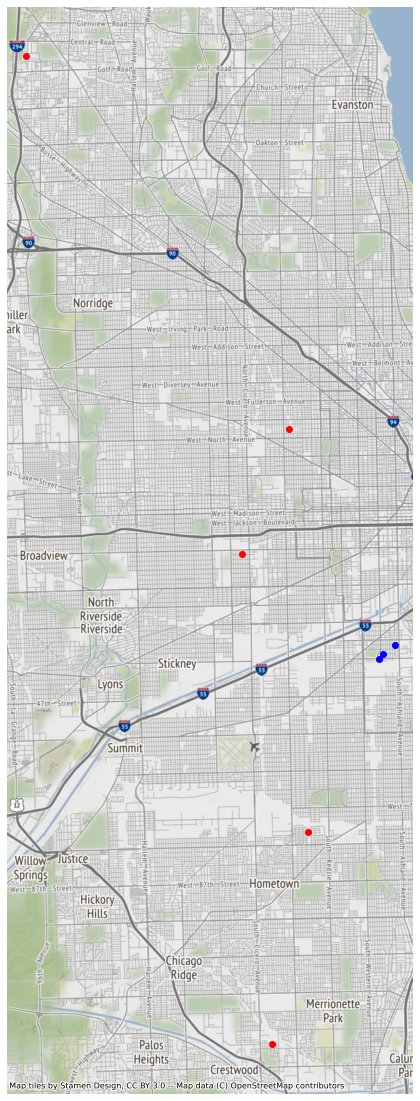

In [12]:
# Plot sensor locations: AirNow in red, PurpleAir in Blue
ax = gdf_an.plot(
    figsize=(20, 20), 
    color='red'
)
gdf_pa.plot(
    ax=ax, 
    color='blue'
)

# Add background map
ctx.add_basemap(ax)

ax.set_axis_off()

plt.savefig('figures/sensor_locations_PM.png', bbox_inches='tight', dpi=600)

# Plot timeseries data

In [59]:
def plot_seasonal_trends(df_data, df_sensors):
    """Plot data for season, for each sensor separately"""
    
    nSensors = len(df_sensors.index)
    figure, axis = plt.subplots(nSensors)
    figure.set_figheight(10)

    dataMin = min(df_data['concentration'])
    dataMax = max(df_data['concentration'])
    buffer = 0.05*(dataMax - dataMin)
    
    colors = ['green', 'pink']
    for i, sensor in df_sensors.iterrows():
        # Get data corresponding to current sensor
        df_sensor = df_data.loc[(df_data['latitude'] == sensor['latitude']) &
                                (df_data['longitude'] == sensor['longitude'])]
        
        # Plot data for each season separately
        for j, season in enumerate(SEASONS):
            df_season = df_sensor.loc[df_sensor['season'] == season].copy()
            df_season.sort_values(by='datetime', inplace=True)
            
            axis[i].plot(df_season['datetime'], df_season['concentration'], color=colors[j])
        
        # Format plot
        axis[i].set_ylabel("Concentration\n(ug/m3)")
        axis[i].set_title(f"({sensor['latitude']}, {sensor['longitude']})")
        axis[i].set_ylim([dataMin - buffer, dataMax + buffer])
        if i < nSensors-1:
            axis[i].set_xticklabels([])

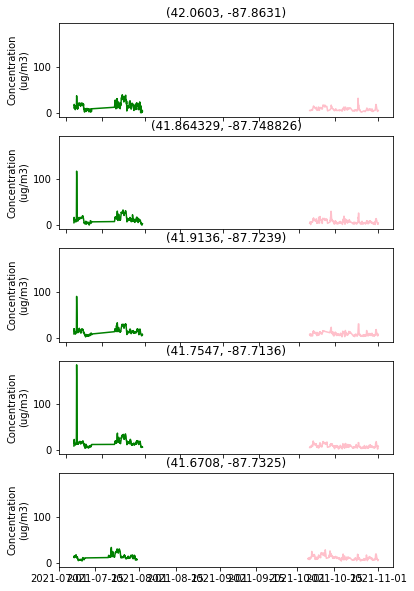

In [60]:
plot_seasonal_trends(df_an_pm25, sensorCoords_an)

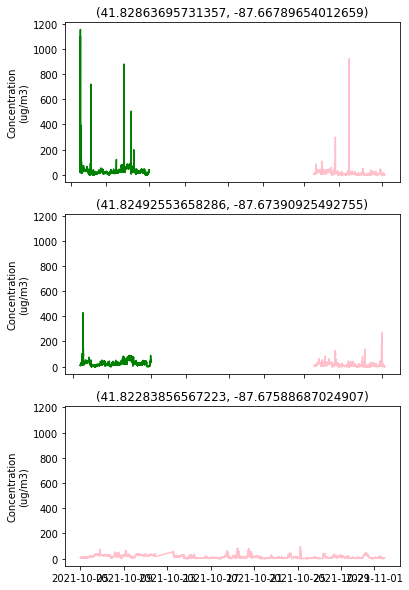

In [61]:
plot_seasonal_trends(df_pa_pm25, sensorCoords_pa)